In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tikzplotlib
import os

import scipy.stats as st

In [2]:
scratchHPC = r'\\rb-hpc.de.bosch.com\hro7rng\scratch\MultiPhase'

In [3]:
StudienOrdner = '211018_VolStudie_Stresscontrolled_1_HRC60'
StudienOrdner = os.path.join(scratchHPC, StudienOrdner)


ImageOrdner = os.path.join(StudienOrdner, '_image' )

if not os.path.exists(ImageOrdner):
    os.makedirs(ImageOrdner)

In [4]:
lf_csv = r'_eval/lifetime.csv'
lf_csv = os.path.join(StudienOrdner, lf_csv)

In [5]:
df_lf = pd.read_csv(lf_csv)

In [6]:
ll_volf = df_lf['ModelName'].tolist()
ll_volf = [float(kk[kk.rfind('_')+15:])   for kk in ll_volf]

ll_Seed = df_lf['ModelName'].tolist()
ll_Seed = [str(kk[kk.find('_')+5:kk.find('_Str')])   for kk in ll_Seed]

In [7]:
minimia_vol = min(ll_volf)
maxima_vol = max(ll_volf)

In [8]:
df_lf['Volume_Martensite'] = ll_volf
df_lf['Seed'] = ll_Seed

df_wholMod = df_lf[df_lf['Phase']=='wholeMod']

In [9]:
norm = matplotlib.colors.Normalize(vmin=minimia_vol, vmax=maxima_vol, clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=norm) 

In [10]:
from scipy import optimize

def tfunktion(x_data, a,b):
    return a*(x_data**2)+b*x_data+x_data


In [11]:
params, params_covariance = optimize.curve_fit(tfunktion, df_wholMod['Lifetime'].tolist(), df_wholMod['StrainAmplitude'].tolist(),)

In [12]:
colorswhole = df_wholMod['Volume_Martensite'].tolist()
un_voll = np.unique(colorswhole)
colorswhole = [float(c) for c in colorswhole]

strain_ll = np.unique(df_wholMod['StrainAmplitude'].tolist())

dic_f_curve = {}
for  vol in un_voll:
    df_red = df_wholMod[df_wholMod['Volume_Martensite']==vol]
    params, params_covariance = optimize.curve_fit(tfunktion, df_red['Lifetime'].tolist(), df_red['StrainAmplitude'].tolist())
    
    ll_mean_lifetimes = [np.min(df_red[df_red['StrainAmplitude']==stra]['Lifetime'].tolist()) for stra in strain_ll]
    print(ll_mean_lifetimes)
    f_curve = [tfunktion(lf, params[0], params[1]) for lf in ll_mean_lifetimes]
    dic_f_curve[vol] = f_curve

print(dic_f_curve)

ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:

plt.scatter(df_wholMod['Lifetime'], df_wholMod['StressAmplitude'], c=colorswhole)
cbar = plt.colorbar(mapper)
cbar.set_label('Volume Fraction of Martensite in %')
plt.xscale('log')
plt.title('Crack Initiiation Whole Model')
plt.xlabel('Number of Cycles')
plt.ylabel('Strain')
#plt.show()

tikzplotlib.save(os.path.join(StudienOrdner, 'ScatterLifetimeWholeMod.tex'))
plt.savefig(os.path.join(StudienOrdner, 'ScatterLifetimeWholeMod.png'), bbox_inches='tight', dpi=150, transparent=True)

In [13]:
df_Ferrite = df_lf[df_lf['Phase']=='Ferrite']

In [14]:
colorsFerr = df_Ferrite['Volume_Martensite'].tolist()
colorsFerr = [float(c) for c in colorsFerr]

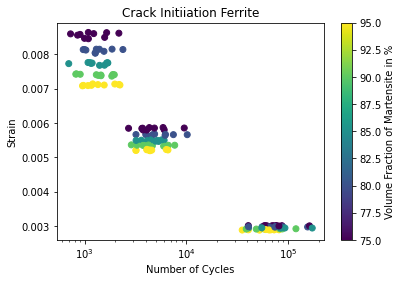

In [15]:
plt.scatter(df_Ferrite['Lifetime'], df_Ferrite['StrainAmplitude'], c=colorsFerr)
cbar = plt.colorbar()
cbar.set_label('Volume Fraction of Martensite in %')
plt.xscale('log')
plt.title('Crack Initiiation Ferrite')
plt.xlabel('Number of Cycles')
plt.ylabel('Strain')
plt.show()

In [16]:
df_mart = df_lf[df_lf['Phase']=='Martensite']

In [17]:
colorsMart = df_mart['Volume_Martensite'].tolist()
colorsMart = [int(c) for c in colorsMart]

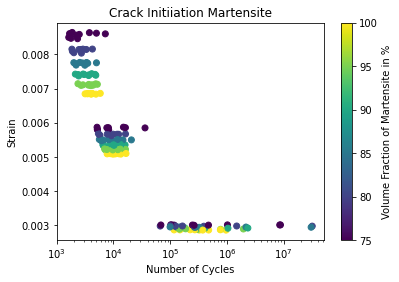

In [18]:
plt.scatter(df_mart['Lifetime'], df_mart['StrainAmplitude'], c=colorsMart)
cbar = plt.colorbar(mapper)
cbar.set_label('Volume Fraction of Martensite in %')
plt.xscale('log')
plt.title('Crack Initiiation Martensite')
plt.xlabel('Number of Cycles')
plt.ylabel('Strain')
plt.show()

Abwärts erstelle confidence intervalle

In [19]:
strainll = np.unique(df_wholMod['StressAmplitude'].tolist())
dic_df_conf = {}
ch_df = {'whole': df_wholMod, 'Ferrite': df_Ferrite, 'Martensite': df_mart}
dd_ll = ['whole','Ferrite','Martensite']
for dd in dd_ll:
    df_conf = pd.DataFrame({'StressAmplitude': strainll})
    for vols in np.unique(ll_volf):
        mean = []
        l_bound= []
        u_bound =  []
        for strain in strainll:
            rdf = ch_df[dd][ch_df[dd]['Volume_Martensite'] == vols]
            rdf = rdf[rdf['StressAmplitude'] == strain]
            a = rdf['Lifetime'].tolist()
            if len(a) != 0:
                s_mean = np.mean(a)
                sl_bound, su_bound = st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))
                if sl_bound<0:
                    sl_bound = min(a)
            if len(a) == 0:
                s_mean,sl_bound, su_bound = np.NaN,np.NaN,np.NaN

            mean.append(s_mean), l_bound.append(sl_bound), u_bound.append(su_bound)
        df_conf['l_bound VolF '+ str(vols)] = l_bound
        df_conf['mean VolF '+ str(vols)] = mean
        df_conf['u_bound VolF '+ str(vols)] = u_bound
    dic_df_conf[dd] = df_conf

Plotten der confidence Intervalle

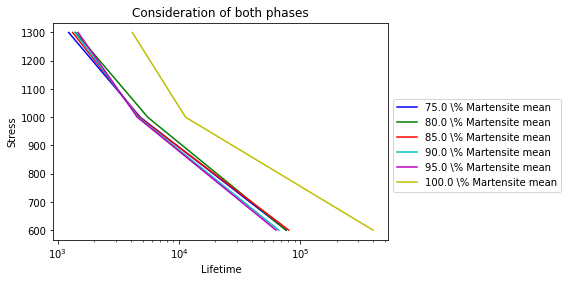

In [20]:
colorlist = ['b', 'g', 'r', 'c', 'm', 'y']
df_conf = dic_df_conf['whole']

for num, vols in enumerate(np.unique(ll_volf)):

    plt.plot(df_conf['mean VolF ' + str(vols)],df_conf['StressAmplitude'], label= (str(vols)+' \% Martensite mean'), color=colorlist[num])
    #plt.fill_betweenx(df_conf['StrainAmplitude'], df_conf['l_bound VolF ' + str(vols)], df_conf['u_bound VolF ' + str(vols)], color=colorlist[num], alpha=.2, label=' confidence interval 95\%')
plt.xscale('log')
plt.legend(loc= 'lower left',bbox_to_anchor=(1.0, 0.2))#, ncol=2 )

plt.ylabel('Stress')
plt.xlabel('Lifetime')

plt.title('Consideration of both phases')


tikzplotlib.save(os.path.join(ImageOrdner, 'ConfLifetimeWholeMod.tex'))
plt.savefig(os.path.join(ImageOrdner, 'ConfLifetimeWholeMod.png'), bbox_inches='tight', dpi=150, transparent=True)

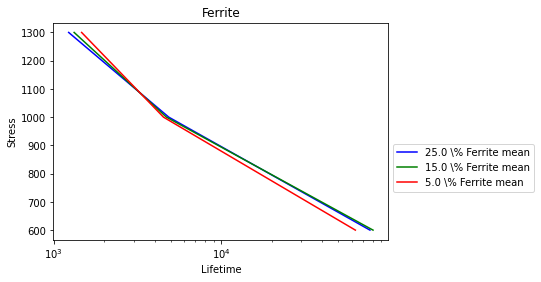

In [21]:
colorlist = ['b', 'g', 'r', 'c', 'm', 'y']
df_conf = dic_df_conf['Ferrite']
volls_red = []
for num, vols in enumerate(np.unique(ll_volf)):
    if vols in [95.0, 85.0,75.0]:
        volls_red.append(vols)
    
for num, vols in enumerate(volls_red):
    plt.plot(df_conf['mean VolF ' + str(vols)],df_conf['StressAmplitude'], label= (str(100-vols)+' \% Ferrite mean'), color=colorlist[num])
    #plt.fill_betweenx(df_conf['StrainAmplitude'], df_conf['l_bound VolF ' + str(vols)], df_conf['u_bound VolF ' + str(vols)], color=colorlist[num], alpha=.2, label=' confidence interval 95\%')
plt.xscale('log')
plt.legend(loc= 'lower left',bbox_to_anchor=(1.0, 0.2))#, ncol=2 )

plt.ylabel('Stress')
plt.xlabel('Lifetime')
plt.title('Ferrite')


tikzplotlib.save(os.path.join(ImageOrdner, 'ConfLifetimeFerrite.tex'))

plt.savefig(os.path.join(ImageOrdner, 'ConfLifetimeFerrite.png'), bbox_inches='tight', dpi=150, transparent=True)

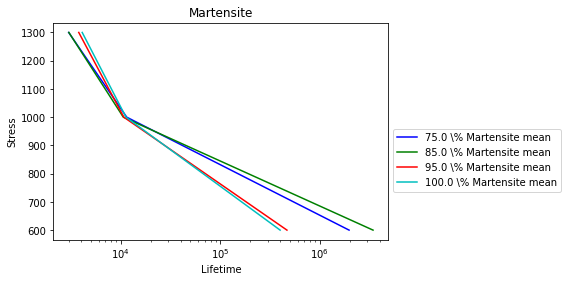

In [22]:
colorlist = ['b', 'g', 'r', 'c', 'm', 'y']
df_conf = dic_df_conf['Martensite']
volls_red = []
for num, vols in enumerate(np.unique(ll_volf)):
    if vols in [100.0, 95.0 ,85.0 ,75.0]:
        volls_red.append(vols)
    
for num, vols in enumerate(volls_red):
    plt.plot(df_conf['mean VolF ' + str(vols)],df_conf['StressAmplitude'], label= (str(vols)+' \% Martensite mean'), color=colorlist[num])
    #plt.fill_betweenx(df_conf['StrainAmplitude'], df_conf['l_bound VolF ' + str(vols)], df_conf['u_bound VolF ' + str(vols)], color=colorlist[num], alpha=.2, label=' confidence interval 95\%')
plt.xscale('log')
plt.legend(loc = 'lower left',bbox_to_anchor=(1.0, 0.2))#, ncol=2 )

plt.title('Martensite')
plt.ylabel('Stress')
plt.xlabel('Lifetime')

tikzplotlib.save(os.path.join(ImageOrdner, 'ConfLifetimeMartensite.tex'))

plt.savefig(os.path.join(ImageOrdner, 'ConfLifetimeMartensite.png'), bbox_inches='tight', dpi=150, transparent=True)

In [23]:
### AChtung lower bound ist nicht ganz korrekt das dieser durch die große varianz eine negative Lebensdauer angeben würde
### dacher ist in diesen Fällen der Lower Bound = minimum der Lebenszeit für definierte Dehnung und Volumengehalt

In [24]:
mnbv= df_lf[df_lf['StressAmplitude']==1300.0]
mnbv= mnbv[mnbv['Seed']=='93426']
mnbv[mnbv['Volume_Martensite'].isin([95.0,75.0])]

,Unnamed: 0,ModelName,ModelGroup,Lifetime,Phase,_LoadingMode,StrainAmplitude,StrainMean,StressAmplitude,StressMean,FIPmax,FIPmaxLocal,FIPcrit,m_FIP,IsExperimentalData,Volume_Martensite,Seed
75,28.0,StressTest1_Seed93426_Stress1300_VolumeFraction95,ALL,953.598041,wholeMod,0.0,0.007087,9.200000e-07,1300.0,0.0,0.047161,0.081646,2.521240,1.724138,0,95.0,93426
76,28.1,StressTest1_Seed93426_Stress1300_VolumeFraction95,ALL,3995.426032,Martensite,0.0,0.007087,9.200000e-07,1300.0,0.0,0.004202,0.009288,0.515708,1.724138,0,95.0,93426
77,28.2,StressTest1_Seed93426_Stress1300_VolumeFraction95,ALL,953.598041,Ferrite,0.0,0.007087,9.200000e-07,1300.0,0.0,0.047161,0.081646,2.521240,1.724138,0,95.0,93426
265,95.0,StressTest1_Seed93426_Stress1300_VolumeFraction75,ALL,1647.014579,wholeMod,0.0,0.008636,8.320000e-06,1300.0,0.0,0.034350,0.172807,2.521240,1.724138,0,75.0,93426
266,95.1,StressTest1_Seed93426_Stress1300_VolumeFraction75,ALL,1647.014579,Ferrite,0.0,0.008636,8.320000e-06,1300.0,0.0,0.034350,0.172807,2.521240,1.724138,0,75.0,93426
267,95.2,StressTest1_Seed93426_Stress1300_VolumeFraction75,ALL,3782.892233,Martensite,0.0,0.008636,8.320000e-06,1300.0,0.0,0.004338,0.013700,0.515708,1.724138,0,75.0,93426


Bestimme liegt geringste Lebenszeit immer mit Ferrit zusammen? 

In [25]:
#df_lf
ll_model = df_lf['Unnamed: 0'].tolist()

In [26]:
ll_prob_phase = []
for mod in ll_model:
    if mod%1 == 0:
        ltime = df_lf[df_lf['Unnamed: 0'] == mod]['Lifetime']
        
        phases = [g for g in ll_model if int(mod) == int(g) and g!=mod]
        
        for ph in phases:
            if float(df_lf[df_lf['Unnamed: 0'] == ph]['Lifetime']) == float(ltime):
                ll_prob_phase.append([len(phases),df_lf[df_lf['Unnamed: 0'] == ph]['Phase'].values[0]])        

print(np.unique(ll_prob_phase,axis=0))

[['1' 'Martensite']
 ['2' 'Ferrite']
 ['2' 'Martensite']]


In [27]:
ll_prob_phase = []
for mod in ll_model:
    if mod%1 == 0:
        ltime = df_lf[df_lf['Unnamed: 0'] == mod]['Lifetime']
        
        phases = [g for g in ll_model if int(mod) == int(g) and g!=mod]
        ltime = 9e300
        phaseprob = ''
        for ph in phases:
            if float(df_lf[df_lf['Unnamed: 0'] == ph]['Lifetime']) < ltime:
                ltime = float(df_lf[df_lf['Unnamed: 0'] == ph]['Lifetime'])
                phaseprob = df_lf[df_lf['Unnamed: 0'] == ph]['Phase'].values[0]
        ll_prob_phase.append([len(phases),phaseprob])        

print(np.unique(ll_prob_phase,axis=0))

[['1' 'Martensite']
 ['2' 'Ferrite']
 ['2' 'Martensite']]


In [28]:
strainll = np.unique(df_wholMod['StressAmplitude'].tolist())
dic_df_StressAmp = {}
ch_df = {'whole': df_wholMod, 'Ferrite': df_Ferrite, 'Martensite': df_mart}
dd_ll = ['whole','Ferrite','Martensite']
for dd in dd_ll:
    df_conf = pd.DataFrame({'StressAmplitude': strainll})
    for vols in np.unique(ll_volf):
        mean = []
        l_bound= []
        u_bound =  []
        for strain in strainll:
            rdf = ch_df[dd][ch_df[dd]['Volume_Martensite'] == vols]
            rdf = rdf[rdf['StressAmplitude'] == strain]
            a = rdf['StrainAmplitude'].tolist()
            if len(a) != 0:
                s_mean = np.mean(a)
                sl_bound, su_bound = st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))
                if sl_bound<0:
                    sl_bound = min(a)
            if len(a) == 0:
                s_mean,sl_bound, su_bound = np.NaN,np.NaN,np.NaN

            mean.append(s_mean), l_bound.append(sl_bound), u_bound.append(su_bound)
        df_conf['l_bound VolF '+ str(vols)] = l_bound
        df_conf['mean VolF '+ str(vols)] = mean
        df_conf['u_bound VolF '+ str(vols)] = u_bound
    dic_df_StressAmp[dd] = df_conf

Plotten confidence Intervalle bezogen auf Stress::

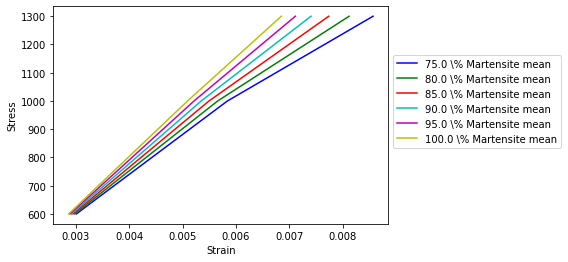

In [29]:
colorlist = ['b', 'g', 'r', 'c', 'm', 'y']

df_conf = dic_df_StressAmp['whole']
for num, vols in enumerate(np.unique(ll_volf)):
    plt.plot(df_conf['mean VolF ' + str(vols)],df_conf['StressAmplitude'], label= (str(vols)+' \% Martensite mean'), color=colorlist[num])
    #plt.fill_betweenx(df_conf['StrainAmplitude'], df_conf['l_bound VolF ' + str(vols)], df_conf['u_bound VolF ' + str(vols)], color=colorlist[num], alpha=.2, label=' confidence interval 95\%')
#plt.xscale('log')
plt.legend(bbox_to_anchor=(1.0, 0.8), ncol=1 )

plt.ylabel('Stress')
plt.xlabel('Strain')
plt.title('')

tikzplotlib.save(os.path.join(ImageOrdner, 'StressAmplitude.tex'))

plt.savefig(os.path.join(ImageOrdner, 'StressAmplitude.png'), bbox_inches='tight', dpi=150, transparent=True)

In [30]:
df_conf

,StressAmplitude,l_bound VolF 75.0,mean VolF 75.0,u_bound VolF 75.0,l_bound VolF 80.0,mean VolF 80.0,u_bound VolF 80.0,l_bound VolF 85.0,mean VolF 85.0,u_bound VolF 85.0,l_bound VolF 90.0,mean VolF 90.0,u_bound VolF 90.0,l_bound VolF 95.0,mean VolF 95.0,u_bound VolF 95.0,l_bound VolF 100.0,mean VolF 100.0,u_bound VolF 100.0
0,600.0,0.003006,0.003009,0.003013,0.002975,0.002978,0.002980,0.002945,0.002947,0.002950,0.002915,0.002919,0.002922,0.002887,0.002890,0.002894,0.002863,0.002866,0.002868
1,1000.0,0.005820,0.005840,0.005861,0.005643,0.005658,0.005672,0.005485,0.005496,0.005506,0.005341,0.005349,0.005358,0.005206,0.005215,0.005224,0.005089,0.005093,0.005098
2,1300.0,0.008519,0.008568,0.008618,0.008088,0.008120,0.008152,0.007718,0.007739,0.007760,0.007392,0.007407,0.007422,0.007100,0.007113,0.007127,0.006844,0.006850,0.006856
